# Image Colorization Using CNN

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from skimage.color import rgb2gray

## Loading Data

In [8]:
(y_train, _), (y_test, _) = cifar10.load_data()

Y_train = y_train[:50000]
Y_test = y_test[:10000]
Y_train = y_train.astype("float32")/255
Y_test = y_test.astype("float32")/255

print(f' Y Training Shape {y_train.shape}')
print(f' Y Test Shape {y_test.shape}')

 Y Training Shape (50000, 32, 32, 3)
 Y Test Shape (10000, 32, 32, 3)


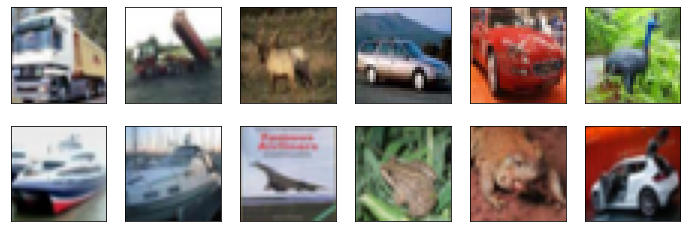

In [9]:
def plot_image(Nrow, Ncol, image_size, channel, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            plt.imshow(image_list[j][i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
plot_image(2, 6, 32, 3, Y_train, Y_test)

## Converting Image from RGB to lab

In [4]:
from IPython.display import display, Image
from matplotlib.pyplot import imshow
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb, rgb2lab

In [10]:
lab_image_train = rgb2lab(Y_train)
lab_image_test = rgb2lab(Y_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


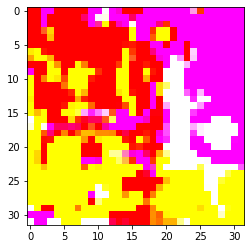

In [11]:
plt.imshow(lab_image_train[1])

## Normalize the Dataset

In [12]:
lab_train_norm = (lab_image_train + [0, 128, 128]) / [100, 255, 255]
lab_test_norm = (lab_image_test + [0, 128, 128]) / [100, 255, 255]

In [13]:
# The input will be the black and white layer
X_train = lab_train_norm[:,:,:,0]
X_test = lab_test_norm[:,:,:,0]

# The outpts will be the ab channels
y_train = lab_train_norm[:,:,:,1:]
y_test = lab_test_norm[:,:,:,1:]

print(f'Input shape: {X_train.shape}')
print(f'Output shape: {y_test.shape}')

Input shape: (50000, 32, 32)
Output shape: (10000, 32, 32, 2)


In [14]:
# Reshape Train Dataset
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 2)

# Reshape Test Dataset
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 2)

In [15]:
print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')

X_train shape (50000, 32, 32, 1)
y_train shape (50000, 32, 32, 2)


## Model Structure

In [23]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3,3), activation='tanh', padding='same'))

# Finish model
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 32)         

In [24]:
%%time
# Fit the model
model.fit(x=X_train, y=y_train, batch_size=100, epochs=1000, verbose=0)

CPU times: user 36min 54s, sys: 2min 16s, total: 39min 10s
Wall time: 40min 34s


In [25]:
model.evaluate(X_train, y_train, batch_size=1)

50000/50000 [==============================] - 83s 2ms/step - loss: 0.0020


0.0019674967043101788

## Save Model

In [26]:
model.save("model.h5")

In [27]:
from keras.models import load_model
model = load_model('model.h5')

In [29]:
# Predict
output = model.predict(X_test)

In [30]:
output.shape

(10000, 32, 32, 2)

In [46]:
# Combining the l and ab channel and convert to RGB format
cur = np.zeros((32, 32, 3))
cur[:,:,0] = X_test[1][:,:,0]
cur[:,:,1:] = output[1]

cur = (cur * [100, 255, 255]) - [0, 128, 128]
rgb_image = lab2rgb(cur)

([], <a list of 0 Text major ticklabel objects>)

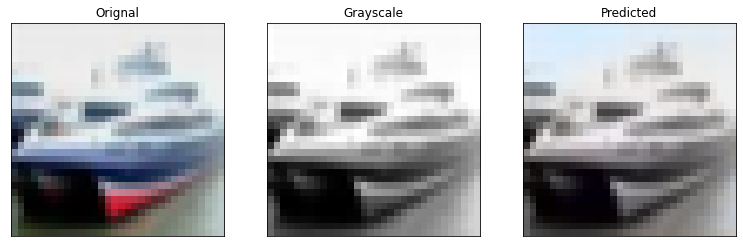

In [52]:
plt.figure(figsize=(13,13))
# Orignal Image
plt.subplot(1,3,1)
plt.imshow(Y_test[1])
plt.title('Orignal')
plt.xticks([])
plt.yticks([])

# Grayscale Image
plt.subplot(1,3,2)
plt.imshow(rgb2gray(Y_test[1]))
plt.title('Grayscale')
plt.xticks([])
plt.yticks([])

# Predicted Image
plt.subplot(1,3,3)
imshow(rgb_image)
plt.title('Predicted')
plt.xticks([])
plt.yticks([])